# Cell Detection

Our ground truth generation is imperfect and does not give a complete annotation of the cell populations as would be required by state-of-the-art detection systems. We therefore opt for crop-wise training, where the bounding boxes of successfully segmented cells are padded, to create $24 \times 24$px crops, centered on the cells. Due to the low image resolution, we found this sizing provided sufficient contextual information to the network. Combined with back- ground crops, this amounts to approximately 100,000 training examples in three classes.

In [1]:
from __future__ import print_function
from __future__ import division

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from IPython.display import Image

Using TensorFlow backend.


In [2]:
mode = 'two-class'
acquisition = 'raw'

x_train = np.load('./x_train_%s_%s.npy' % (acquisition, mode))[:, :, :, np.newaxis]
y_train = np.load('./y_train_%s_%s.npy' % (acquisition, mode))

random_state = 42

x_train_rgb = np.load('./x_train_%s_%s_rgb.npy' % (acquisition, mode))
x_train_rgb, x_test_rgb, _, _ = train_test_split(x_train_rgb,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=random_state)

x_train, x_test, y_train, y_test = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    random_state=random_state)

In [3]:
img_size = x_train.shape[1]

print('Training images', x_train.shape)
print('Training labels', y_train.shape)
print('Test images', x_test.shape)
print('Training labels', y_test.shape)

nb_classes = 3

pad = x_train.shape[1]

print('Class populations', tuple(np.sum(y_train[:, :nb_classes], axis=0).astype('int')))

Training images (84566, 24, 24, 1)
Training labels (84566, 5)
Test images (9397, 24, 24, 1)
Training labels (9397, 5)
Class populations (42325, 32507, 9734)


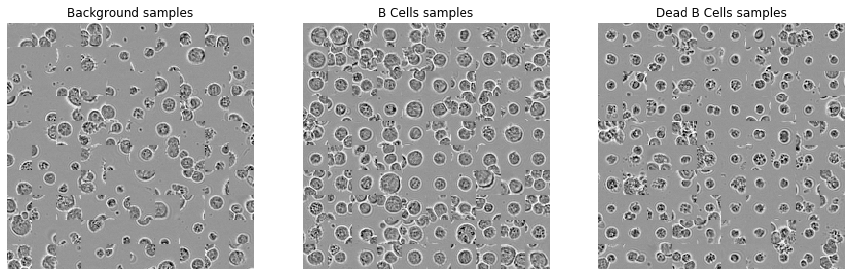

In [4]:
from src.vis_utils import create_mosaic_plot

class_names = ['Background', 'B Cells', 'Dead B Cells']

create_mosaic_plot(x_train, np.argmax(y_train[:, :3], axis=1), class_names)

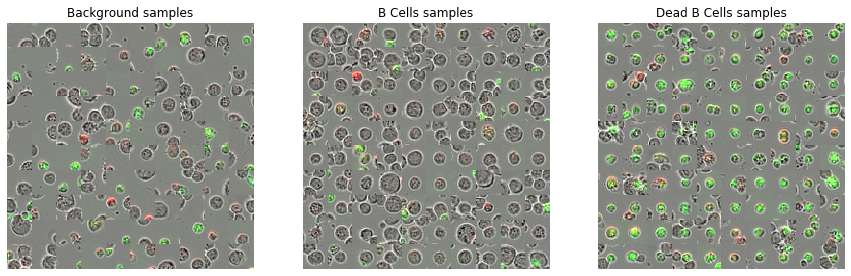

In [5]:
from src.vis_utils import create_mosaic_plot

create_mosaic_plot(x_train_rgb, np.argmax(y_train[:, :3], axis=1), class_names, nb_channels=3)

In [6]:
# take image mean (rather than mean image) to facilitate sliding window
image_mean = np.mean(x_train)

x_train -= image_mean
x_test -= image_mean

## Training as a classifier

Inspired by, we formulate a multi-task prediction in which we predict $Pr(o)$, where $o$ indicates the presence of an object in the center of the receptive field and, separately, $Pr(c|o)$, that is, the probability of cell phenotype class $c$ given the presence of an object. These probabilities are combined at inference time. In addition, our network performs regression on the height h and width w of the bounding box of the cell, measured as a fraction of the crop size from the crop centre. Note that we make the assumption that our chosen crop size represents a hard maximum on the size of a cell's bounding box, a reasonable simplification for our dataset. Our network is therefore trained on mini-batches of size $M$, $\{\mathbf{x}_i, (o_i, c_i, w_i, h_i)\}_{i=1}^M$. We use the loss function,

\begin{align}
\mathcal{L} = \sum_{i=1}^M l_{o}(\hat{o}_i, o_i) + \mathbb{1}_{o}^{i}\big[l_{c}(\hat{c}_i, c_i) + l_{b} (\hat{w}_i, w_i, \hat{h}_i, h_i)\big]
\end{align}

where $l_{o}$ and $l_{c}$ are each a log loss and $l_b$ is mean squared error. The estimates $\hat{o}_i, \hat{c}_i$ $\hat{w}_i$, and $\hat{h}_i$ are the network outputs for object presence, object class, and bounding box width and height. The indicator function $\mathbb{1}_o^i = 1$ when training example $\mathbf{x}_i$ contains an object.

In [7]:
from src.models import MultiFCN

model_tr, model = MultiFCN()
model_tr.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [8]:
from keras.callbacks import ModelCheckpoint
from src.utils import gen_balanced_multi

model_checkpoint = ModelCheckpoint('./weights_classifier_multi.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

batch_size = 128
epochs = 20

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1)

train_gen = gen_balanced_multi(x_tr, y_tr, batch_size, augment=True)

val_gen = gen_balanced_multi(x_val, y_val, 1024)

hist = model_tr.fit_generator(train_gen,
                              epochs=epochs,
                              steps_per_epoch=500,
                              validation_data=next(val_gen),
                              callbacks=[model_checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
500/500 [==============================] - 80s 161ms/step - loss: 0.1313 - o_loss: 0.0344 - c_loss: 0.0679 - b_loss: 0.0190 - val_loss: 0.3822 - val_o_loss: 0.2737 - val_c_loss: 0.0793 - val_b_loss: 0.0192
Epoch 2/20
500/500 [==============================] - 89s 177ms/step - loss: 0.0868 - o_loss: 0.0161 - c_loss: 0.0564 - b_loss: 0.0042 - val_loss: 0.0807 - val_o_loss: 0.0208 - val_c_loss: 0.0455 - val_b_loss: 0.0043
Epoch 3/20
500/500 [==============================] - 88s 176ms/step - loss: 0.0789 - o_loss: 0.0134 - c_loss: 0.0523 - b_loss: 0.0032 - val_loss: 0.0746 - val_o_loss: 0.0157 - val_c_loss: 0.0460 - val_b_loss: 0.0029
Epoch 4/20
500/500 [==============================] - 86s 173ms/step - loss: 0.0742 - o_loss: 0.0124 - c_loss: 0.0493 - b_loss: 0.0026 - val_loss: 0.0667 - val_o_loss: 0.0149 - val_c_loss: 0.0391 - val_b_loss: 0.0028
Epoch 5/20
500/500 [=================

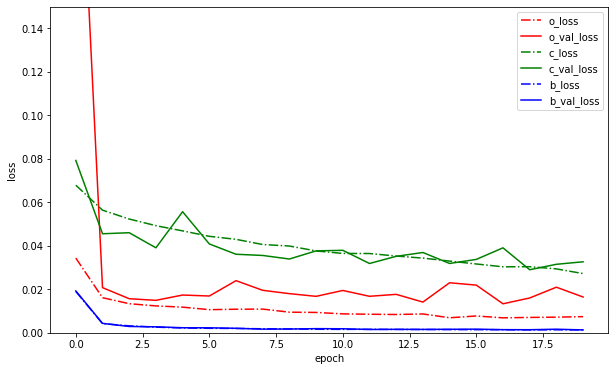

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist.history['o_loss'], linestyle='-.', color='red', label='o_loss')
ax.plot(hist.history['val_o_loss'], linestyle='-', color='red', label='o_val_loss', )

ax.plot(hist.history['c_loss'], linestyle='-.', color='green', label='c_loss')
ax.plot(hist.history['val_c_loss'], linestyle='-', color='green', label='c_val_loss')

ax.plot(hist.history['b_loss'], linestyle='-.', color='blue', label='b_loss')
ax.plot(hist.history['val_b_loss'], linestyle='-', color='blue', label='b_val_loss')

ax.set_ylim([0, 0.15])

ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.legend()

#### Balanced evaluation

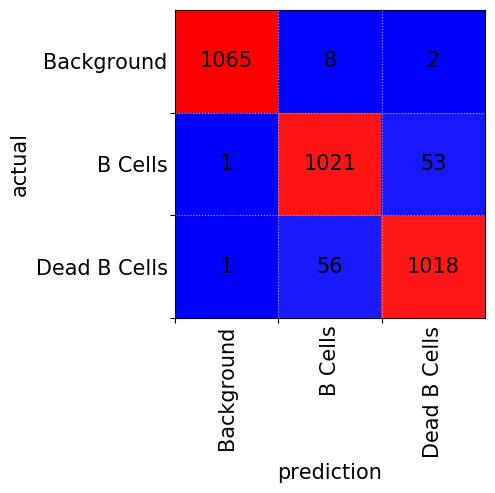

In [10]:
from src.vis_utils import plot_confusion_matrix
from src.utils import downsample_balanced

model.load_weights('./weights_classifier_multi.h5')

x_test_balanced, y_test_balanced = downsample_balanced(x_test, np.argmax(y_test[:, :3], axis=1))

# decode model outputs
pred_proba_obj, pred_proba_cls, pred_proba_bbs = model.predict(x_test_balanced)

pred_obj = np.argmax(pred_proba_obj[:, 0, 0, :], axis=1)
pred_cls = np.argmax(pred_proba_cls[:, 0, 0, :], axis=1)

pred = pred_obj * (pred_cls + 1)

plt.style.use('default')

confusion_matrix = np.zeros((nb_classes, nb_classes), np.int)

for i in range(y_test_balanced.shape[0]):
    confusion_matrix[y_test_balanced.astype('int')[i], pred[i]] += 1

fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(ax, confusion_matrix, class_names, fontsize=15)

In [11]:
from src.utils import mean_precision, mean_recall

print('Mean recall: %.04f' % mean_recall(confusion_matrix))
print('Mean precision: %.04f' % mean_precision(confusion_matrix))

recall = mean_recall(confusion_matrix)
precision = mean_precision(confusion_matrix)
f1 = 2 * (recall * precision) / (recall + precision)

print('F1: %.04f' % f1)

Mean recall: 0.9625
Mean precision: 0.9626
F1: 0.9626


### Visualise separation

In [12]:
from keras.models import Model

cnn_code = Model(model.get_layer('input').input,
                 model.get_layer('cnn_code').output)

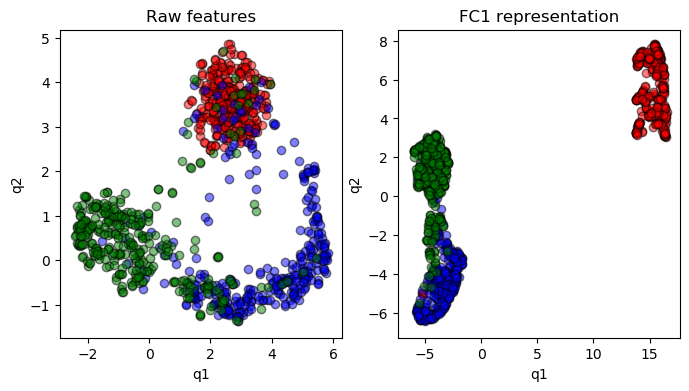

In [13]:
import umap.umap_ as umap
from sklearn.manifold import t_sne
from src.vis_utils import plot_embeddings

_, x_test_small, _, y_test_small = train_test_split(x_test_balanced, y_test_balanced, test_size=1000)

nb_test_balanced = x_test_small.shape[0]
features = cnn_code.predict(x_test_small)[:, 0, 0, :]

umap_model = umap.UMAP(n_components=2)

embedding_raw = umap_model.fit_transform(x_test_small.reshape(nb_test_balanced, pad * pad))
embedding_features = umap_model.fit_transform(features.reshape(nb_test_balanced, 128))

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(1, 2, 1, title='Raw features',
    xlabel='q1', ylabel='q2')

plot_embeddings(ax, embedding_raw, y_test_small)

ax = fig.add_subplot(1, 2, 2, title='FC1 representation',
    xlabel='q1', ylabel='q2')

plot_embeddings(ax, embedding_features, y_test_small)

## Pretrained CNN

We benchmarked our network as a cell classifier against a logistic regression trained on features extracted from a pre-trained 50-layer ResNet. In order to do this, we resized our cropped cells to $32 \times 32$px and recorded the final convolutional layer of the ResNet, a vector of dimension $2048$. Though deep pre-trained networks are known to be powerful general-purpose feature extractors, they may also be over-parameterised for many problems.

In [14]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

resnet = ResNet50(include_top=False, weights='imagenet')

#### Generate bottleneck features

In [15]:
import pickle
from skimage.transform import resize

def proprocess(x_input):
    resized_img = resize(x_input, output_shape=(x_input.shape[0], 32, 32, 1))
    resized_img = (resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))
    resized_img = (255 * resized_img).astype('uint8')

    resized_img = np.stack([resized_img[..., 0],
                            resized_img[..., 0],
                            resized_img[..., 0]], axis=-1)
    return resized_img

x_train_resnet = resnet.predict(proprocess(x_train), verbose=True)
x_test_resnet = resnet.predict(proprocess(x_test), verbose=True)

data = (x_train_resnet, y_train, x_test_resnet, y_test)

pickle.dump(data, open('bottleneck_features.p', 'wb'))

9397/9397 [==============================] - 29s 3ms/step


#### Train linear model

In [16]:
from keras.losses import categorical_crossentropy
from src.models import SoftmaxRegression

model_linear = SoftmaxRegression(input_shape=(2048,), nb_classes=3)

model_linear.compile(loss=categorical_crossentropy,
              optimizer='rmsprop', metrics=['accuracy'])

model_linear.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________


In [17]:
import pickle
from src.utils import gen_balanced

x_train_resnet, y_train, x_test_resnet, y_test = pickle.load(open('bottleneck_features.p', 'rb'))

def gen_wrapper(x_tr, y_tr):
    train_gen = gen_balanced(x_tr, y_tr)

    while True:
        x, y = next(train_gen)
        yield x, y[:, 0, 0]

model_checkpoint = ModelCheckpoint('./weights_softmax.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

nb_epochs = 10

x_tr, x_val, y_tr, y_val = train_test_split(x_train_resnet[:, 0, 0, :], y_train[:, :3], test_size=0.1)

x_val_balanced, y_val_balanced = downsample_balanced(x_val, y_val.argmax(axis=1))
y_val_balanced = to_categorical(y_val_balanced)

train_gen = gen_wrapper(x_tr, y_tr)

hist = model_linear.fit_generator(train_gen, epochs=nb_epochs, steps_per_epoch=200,
                        validation_data=(x_val_balanced, y_val_balanced),
                        validation_steps=1,
                        callbacks=[model_checkpoint])

Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.7566 - val_loss: 0.5041 - val_accuracy: 0.8038
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.8239 - val_loss: 0.4312 - val_accuracy: 0.8307
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.8387 - val_loss: 0.3746 - val_accuracy: 0.8685
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4108 - accuracy: 0.8429 - val_loss: 0.4159 - val_accuracy: 0.8607
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3852 - accuracy: 0.8572 - val_loss: 0.5089 - val_accuracy: 0.8084
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3803 - accuracy: 0.8566 - val_loss: 0.3639 - val_accuracy: 0.8611
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3658 - accuracy: 0.8662 - val_loss: 0.3555 - val_accuracy: 0.8692
Epoch 

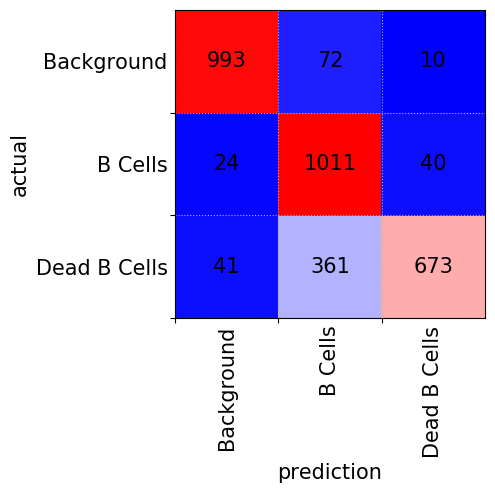

In [18]:
from src.vis_utils import plot_confusion_matrix

model_linear.load_weights('./weights_softmax.h5')

x_test_balanced, y_test_balanced = downsample_balanced(x_test_resnet, np.argmax(y_test[:, :3], axis=1))

pred_proba = model_linear.predict(x_test_balanced[:, 0, 0, :])
pred = np.argmax(pred_proba, axis=1)
ground_truth = y_test_balanced

for i in range(pred.shape[0]):
    if pred[i] == 2 and pred_proba[i, 2] < 0.87:
        pred[i] = 1

plt.style.use('default')

confusion_matrix = np.zeros((nb_classes, nb_classes), np.int)

nb_test = y_test_balanced.shape[0]

for i in range(nb_test):
    confusion_matrix[ground_truth[i], pred[i]] += 1

fig, ax = plt.subplots(figsize=(4, 4))
plot_confusion_matrix(ax, confusion_matrix, class_names, fontsize=15)

In [19]:
print('Mean recall: %.04f' % mean_recall(confusion_matrix))
print('Mean precision: %.04f' % mean_precision(confusion_matrix))

recall = mean_recall(confusion_matrix)
precision = mean_precision(confusion_matrix)
f1 = 2 * (recall * precision) / (recall + precision)

print('F1: %.04f' % f1)

Mean recall: 0.8301
Mean precision: 0.8565
F1: 0.8431


## Inference as a detector

Following Overfeat we designed our network to be \emph{fully convolutional} (FCN). A FCN is capable of performing inference on any size of input, and is extended naturally to object detection. Thus, once trained on cell crops as a classifier, inference may be performed on an entire image in a single forward pass, producing a map of softmax probabilities at every location in the image. Fully-convolutional whole-image inference emulates sliding-window detection, albeit without the tremendous inefficiency of executing the model separately at every spatial position. Note that the resolution of the output will depend on the number of pooling layers in the network. For example, our network includes two max pooling layers, hence we make detections at a stride of $4$ across the input image surface.

At inference time, the object and conditional class probabilities are combined to give the marginal class probabilities $Pr(c) = Pr(c | o) \cdot Pr(o)$. Note that $Pr(c | \neg o) = 0$. These probabilities are thresholded and pruned with non-maximum suppression (NMS), providing a final detection mask for each class. For the NMS algorithm, we use an intersection over union threshold of 0.35

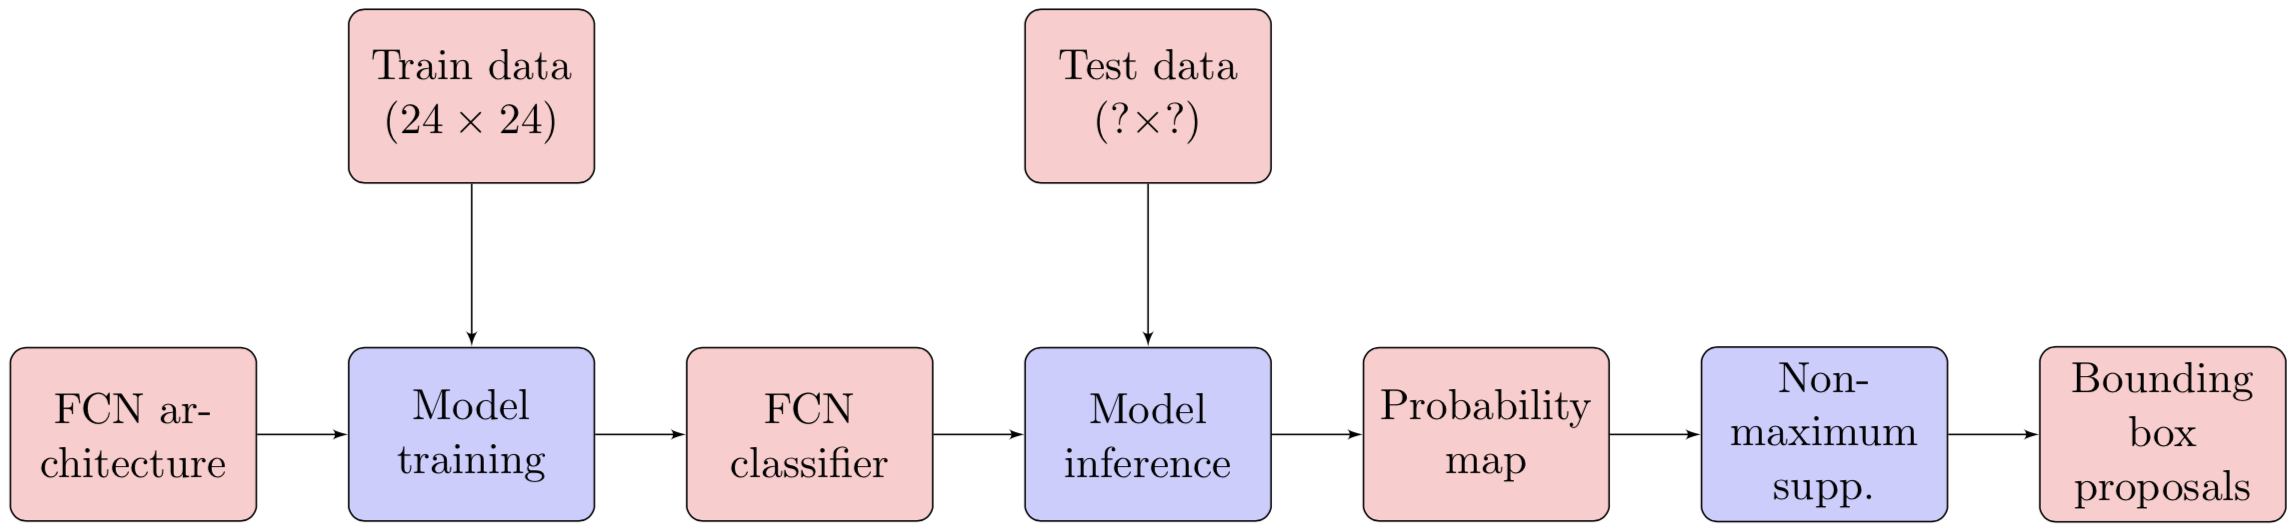

In [20]:
Image('./img/classifier_pipeline.png')

In [21]:
from src.utils import get_files, get_data

base_dir = '/Users/jcboyd/Dropbox/test_crops/'

experiment = 'raji_target'
days = 3

train_imgs, _, test_imgs = get_files(base_dir, experiment, days)
test_imgs = train_imgs

No. train images: 36
No. val images: 0
No. test images: 36


In [22]:
mode = 'stacked'
pretrained = False
normalise = False

x_test, y_test = get_data(base_dir, test_imgs, mode, pretrained, normalise)

x_test = np.clip(x_test, 0, 255) / float(255)
y_test = np.clip(y_test, 0, 255) / float(255)

idx = 10

phase_contrast = x_test[idx]
gfp = y_test[idx, ..., 0]
mcherry = y_test[idx, ..., 1]

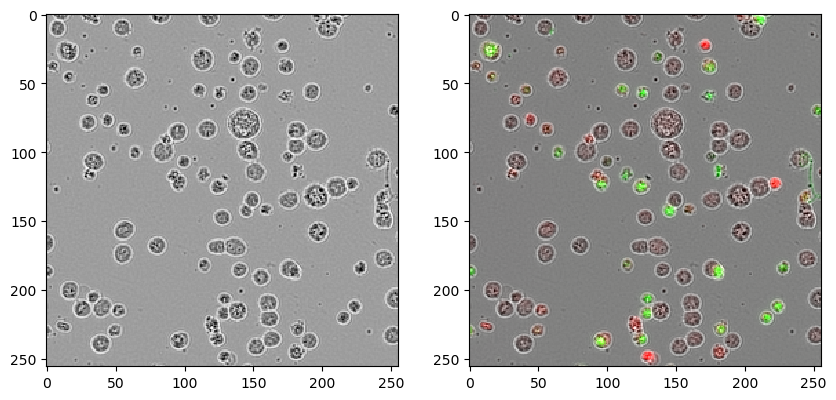

In [23]:
from skimage.io import imread, imsave
from src.vis_utils import visualise_rgb

img = visualise_rgb(mcherry, gfp, phase_contrast)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(phase_contrast, cmap='Greys_r')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img)

In [24]:
from keras.models import Model
from src.utils import pad_input

model_logits = Model(model.get_layer('input').input,
                     model.get_layer('logits_cls').output)

# pad inputs to acquire likely sized output
padded_pc = pad_input(x_test[idx] - image_mean, pad_width=11)

logits = model_logits.predict(padded_pc)
print('Shape of probaility map:', logits.shape)

Shape of probaility map: (1, 64, 64, 2)


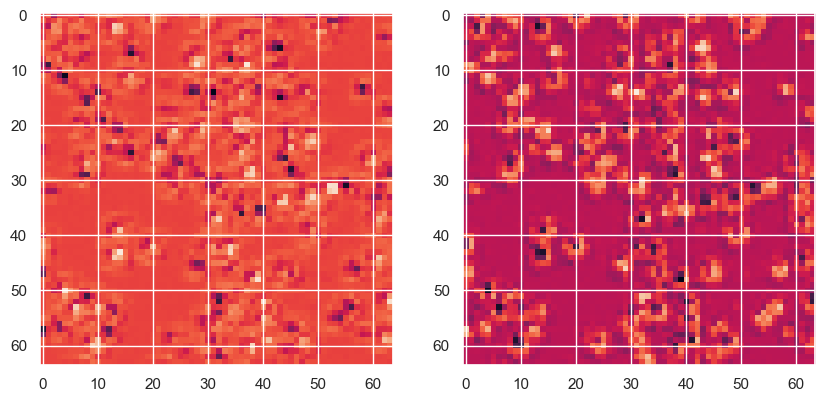

In [25]:
sns.set()

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

for i, ax in enumerate(axes):
    ax.imshow(logits[0, :256//2, :256//2, i])

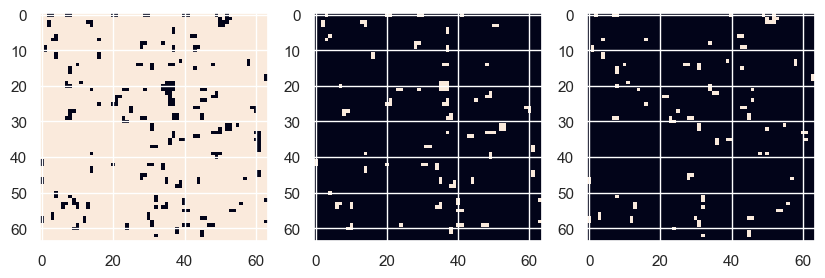

In [26]:
obj_probs, cls_probs, bbs_probs = model.predict(padded_pc)

t = 0.6

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(obj_probs[0, ..., 0] > t)

ax = fig.add_subplot(1, 3, 2)
ax.imshow((cls_probs[0, ..., 0] * (obj_probs[0, ..., 1] > 0.5)) > t)

ax = fig.add_subplot(1, 3, 3)
ax.imshow((cls_probs[0, ..., 1] * (obj_probs[0, ..., 1] > 0.5)) > t)

### Smoothing probabilties in time

Because the cells are relatively stationary, we can improve the prediction of our system by leveraging information across time. We find a simple weighted average of prediction probabilities from consecutive frames, computed prior to NMS, improves overall performance. We thus define the \emph{smoothed} probability $p_{ij}^{(t)} \leftarrow 1/4\cdot p_{ij}^{(t-1)} + 1/2\cdot p_{ij}^{(t)} + 1/4 \cdot p_{ij}^{(t+1)}$ for the probability at image position $(i, j)$ at time $t$.

In [27]:
from src.utils import nms, smooth_probabilties, create_masks

all_img = np.vstack([pad_input(x - image_mean, pad_width=11) for x in x_test])

all_obj_probs, all_cls_probs, all_bbs_probs = model.predict(all_img)
probs = (all_obj_probs[..., 1:] * all_cls_probs)

padded_probs = np.vstack([probs[0:1], probs, probs[-1:]])

smoothed_probs_raji = np.array([smooth_probabilties(padded_probs[i-1:i+2, ..., 0], alpha=0.33)
                           for i in range(1, padded_probs.shape[0] - 1)])

smoothed_probs_dead = np.array([smooth_probabilties(padded_probs[i-1:i+2, ..., 1], alpha=0.33)
                           for i in range(1, padded_probs.shape[0] - 1)])

smoothed_probs = np.stack([smoothed_probs_raji, smoothed_probs_dead], axis=-1)

In [28]:
from ipywidgets import interact, IntSlider


prob_threshold = 0.5
iou_threshold = 0.1

def browse_images(x_test, cmap='Greys'):

    num_frames = x_test.shape[0]

    def view_image(i):

        detections = nms(smoothed_probs[i:i+1].copy(), all_bbs_probs[i:i+1].copy(),
                         prob_threshold, iou_threshold)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(x_test[i], cmap=cmap)
    
        for bb in detections:

            y_min, x_min, y_max, x_max, cls = bb

            colour = 'green' if cls else 'red'

            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1, edgecolor=colour, facecolor='none')
            ax.add_patch(rect)

        plt.show()

    interact(view_image, i=IntSlider(min=0, max=num_frames-1, step=1))

browse_images(x_test)

interactive(children=(IntSlider(value=0, description='i', max=35), Output()), _dom_classes=('widget-interact',…

#### Import ground truth annotations

In [29]:
from src.utils import import_annotations

annotations_dir = './zenodo/test/labels/'
plate = 'VID193_A5_4'

arr_num_dead, arr_num_raji, gt_b_masks, gt_d_masks = import_annotations(annotations_dir, plate)

/Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py:54: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 54 of the file /Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(fp)


In [30]:
b_masks, d_masks = [], []
b_counts, d_counts = [], []

N, h, w = x_test.shape

for i in range(N):

    detections = nms(smoothed_probs[i:i+1].copy(), all_bbs_probs[i:i+1].copy(),
                     prob_threshold, iou_threshold)

    b_centers, d_centers = [], []

    for bbs in detections:
        y_min, x_min, y_max, x_max, cls = bbs

        if cls == 0:
            b_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])
        else:
            d_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])

    b_centers = np.array(b_centers)
    d_centers = np.array(d_centers)

    b_counts.append(b_centers.shape[0])
    d_counts.append(d_centers.shape[0])

    b_mask, d_mask = create_masks(h, w, b_centers, d_centers)

    b_masks.append(b_mask)
    d_masks.append(d_mask)

In [31]:
mean_count_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]))
mean_count_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]))

mean_perc_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]) / arr_num_raji[:N])
mean_perc_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]) / arr_num_dead[:N])

print('Mean err. RAJI %.04f' % mean_count_err_raji)
print('Mean err. Dead %.04f' % mean_count_err_dead)

print('Mean perc err. RAJI %.04f' % mean_perc_err_raji)
print('Mean perc err. Dead %.04f' % mean_perc_err_dead)

Mean err. RAJI 1.9722
Mean err. Dead 2.1111
Mean perc err. RAJI 0.0395
Mean perc err. Dead 0.0411


In [32]:
from src.utils import evaluate

b_tps_list, b_fps_list, b_fns_list = [], [], []
d_tps_list, d_fps_list, d_fns_list = [], [], []

for i in range(N):
    tps, fps, fns = evaluate(gt_b_masks[i], b_masks[i], max_dist=10)
    b_tps_list.append(tps)
    b_fps_list.append(fps)
    b_fns_list.append(fns)

    tps, fps, fns = evaluate(gt_d_masks[i], d_masks[i], max_dist=10)
    d_tps_list.append(tps)
    d_fps_list.append(fps)
    d_fns_list.append(fns)

In [33]:
from src.utils import calculate_recall, calculate_precision, calculate_f1

tps = np.sum(b_tps_list)
fps = np.sum(b_fps_list)
fns = np.sum(b_fns_list)

precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.9534 Recall 0.8192 F1 0.8812


In [34]:
tps = np.sum(d_tps_list)
fps = np.sum(d_fps_list)
fns = np.sum(d_fns_list)

precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.6303 Recall 0.9313 F1 0.7518


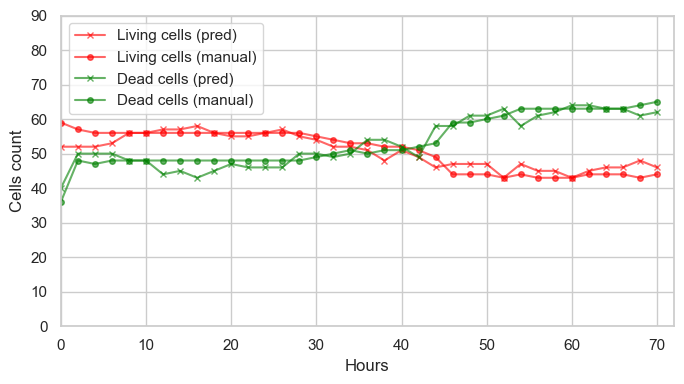

In [35]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(7, 4))

x_range = range(0, 2 * N, 2)

ax.set_xlim([0, 72])
ax.set_ylim([0, 90])

ax.plot(x_range, np.array(b_counts), marker='x', markersize=4,
        color='Red', label='Living cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_raji, marker='o', markersize=4,
        color='Red', label='Living cells (manual)', alpha=0.6)
ax.plot(x_range, np.array(d_counts), marker='x', markersize=4,
        color='Green', label='Dead cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_dead, marker='o', markersize=4,
        color='Green', label='Dead cells (manual)', alpha=0.6)

ax.set_xlabel('Hours')
ax.set_ylabel('Cells count')

plt.tight_layout()
plt.legend()

plt.show()